In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import sys
import os
import pandas as pd
import backtrader as bt
import matplotlib

In [2]:
# Download latest version
path = kagglehub.dataset_download("khalilvandian/portfolio-management")

# List all files and directories in the downloaded dataset path
files = os.listdir(path)
print("Files in dataset directory:", files)

100%|██████████| 651k/651k [00:00<00:00, 2.01MB/s]

Extracting files...
Files in dataset directory: ['AVGO.csv', 'AXP.csv', 'BAC.csv', 'CB.csv', 'CMG.csv', 'EA.csv', 'EBAY.csv', 'GRMN.csv', 'IBM.csv', 'IT.csv', 'LEG.csv', 'MHK.csv', 'MS.csv', 'ORLY.csv', 'XL.csv']


In [3]:
def clean_stock_data(filepath):
    df = pd.read_csv(filepath)

    # Standardize column names (lowercase, no special characters)
    df.columns = [col.strip().lower().replace('/', '_').replace(' ', '_') for col in df.columns]

    # Rename 'close/last' to 'close' if needed
    if 'close_last' in df.columns:
        df.rename(columns={'close_last': 'close'}, inplace=True)

    # Remove dollar signs and convert to float
    df['close'] = df['close'].replace('[\\$,]', '', regex=True).astype(float)
    df['open'] = df['open'].replace('[\\$,]', '', regex=True).astype(float)
    df['high'] = df['high'].replace('[\\$,]', '', regex=True).astype(float)
    df['low'] = df['low'].replace('[\\$,]', '', regex=True).astype(float)

    # Parse dates
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

    return df

In [4]:
stock_data_dict = {}
full_date_index = pd.date_range(start="2015-06-16", end="2025-06-13", freq='B')

for file in files: 
    ticker_name = file.replace(".csv", "").strip()
    file_path = os.path.join(path, file)

    stock_df = clean_stock_data(file_path)
    stock_df = stock_df.reindex(full_date_index)
    stock_df.ffill(inplace=True) 
    stock_df.fillna(0, inplace=True)

    stock_data_dict[ticker_name] = stock_df


# Add no risk option
# copy 1st df and change all values to a constant value
no_risk = stock_data_dict["AVGO"].copy()
no_risk["close"] = 1
no_risk["open"] = 1
no_risk["high"] = 1
no_risk["low"] = 1
no_risk["volume"] = 0
stock_data_dict["NoRisk"] = no_risk

tickers = list(stock_data_dict.keys())
print(tickers)

['AVGO', 'AXP', 'BAC', 'CB', 'CMG', 'EA', 'EBAY', 'GRMN', 'IBM', 'IT', 'LEG', 'MHK', 'MS', 'ORLY', 'XL', 'NoRisk']


In [5]:
# Find and print tickers with any NaN in their "close" column
for ticker, df in stock_data_dict.items():
	if df["close"].isna().any():
		print(f"{ticker} has NaN values in 'close':")
		print(df[df["close"].isna()])

In [6]:

no_risk

,close,volume,open,high,low
2015-06-16,1,0,1,1,1
2015-06-17,1,0,1,1,1
2015-06-18,1,0,1,1,1
2015-06-19,1,0,1,1,1
2015-06-22,1,0,1,1,1
...,...,...,...,...,...
2025-06-09,1,0,1,1,1
2025-06-10,1,0,1,1,1
2025-06-11,1,0,1,1,1
2025-06-12,1,0,1,1,1


In [7]:
class BuyAndHoldCustom(bt.Strategy):

    # Add a parameters class to accept allocations
    params = (('allocations', {}),)

    def __init__(self):
        self.bought = {}
        # Access the allocations from the parameters
        self.allocations = self.p.allocations

    def next(self):
        for data in self.datas:
            name = data._name
            if not self.getposition(data).size and name not in self.bought:
                cash = self.broker.get_cash()
                allocation = self.params.allocations[name]
                size = int(allocation / data.close[0])
                self.buy(data=data, size=size)
                self.bought[name] = True

    def stop(self):
        # Called at the end of the backtest
        for data in self.datas:
            position = self.getposition(data)
            if position.size > 0:
                self.sell(data=data, size=position.size)
                # print(f"SELL at END: {data._name} @ {data.close[0]:.2f}, Size: {position.size}")

def run_custom_backtest(dataframes_dict, allocations_dict, start_date, end_date, budget):
    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(budget)

    filtered_dataframes = {}
    for stock_name, df in dataframes_dict.items():
        df = df.copy()
        # df['Date'] = pd.to_datetime(df['date'])
        # df.set_index('Date', inplace=True)
        df = df.loc[start_date:end_date]
        df.columns = df.columns.str.capitalize()  # Ensure 'Close' column exists
        filtered_dataframes[stock_name] = df
        feed = bt.feeds.PandasData(dataname=df)
        cerebro.adddata(feed, name=stock_name)

    # Pass allocations into strategy as parameter
    cerebro.addstrategy(BuyAndHoldCustom, allocations=allocations_dict)

    start_value = round(cerebro.broker.getvalue(), 2)
    cerebro.run()
    end_value = round(cerebro.broker.getvalue(), 2)

    return {
        'start_value': round(start_value, 2),
        'end_value': round(end_value, 2),
        'total_gain': round(end_value - start_value, 2),
        'percent_gain': round((end_value - start_value) / (start_value) * 100, 2),
        'cerebro': cerebro
    }

In [8]:

# create dataframe for the investment
investment_strategy = pd.DataFrame(tickers, columns=["Symbol"])

# set budget as 1 dollar
budget = 100000

investment_strategy["Weight"] = round(1/len(investment_strategy), 3)
investment_strategy["Position_Size"] = budget * investment_strategy["Weight"]

investment_strategy

,Symbol,Weight,Position_Size
0,AVGO,0.062,6200.0
1,AXP,0.062,6200.0
2,BAC,0.062,6200.0
3,CB,0.062,6200.0
4,CMG,0.062,6200.0
5,EA,0.062,6200.0
6,EBAY,0.062,6200.0
7,GRMN,0.062,6200.0
8,IBM,0.062,6200.0
9,IT,0.062,6200.0


Strategy: 1, Month: 2025-01, File: top_1_weights_2025-01.csv
Strategy: 1, Month: 2025-02, File: top_1_weights_2025-02.csv
Strategy: 1, Month: 2025-03, File: top_1_weights_2025-03.csv
Strategy: 1, Month: 2025-04, File: top_1_weights_2025-04.csv
Strategy: 1, Month: 2025-05, File: top_1_weights_2025-05.csv
Strategy: 1, Month: 2025-06, File: top_1_weights_2025-06.csv
Strategy: 2, Month: 2025-01, File: top_2_weights_2025-01.csv
Strategy: 2, Month: 2025-02, File: top_2_weights_2025-02.csv
Strategy: 2, Month: 2025-03, File: top_2_weights_2025-03.csv
Strategy: 2, Month: 2025-04, File: top_2_weights_2025-04.csv
Strategy: 2, Month: 2025-05, File: top_2_weights_2025-05.csv
Strategy: 2, Month: 2025-06, File: top_2_weights_2025-06.csv
Strategy: 3, Month: 2025-01, File: top_3_weights_2025-01.csv
Strategy: 3, Month: 2025-02, File: top_3_weights_2025-02.csv
Strategy: 3, Month: 2025-03, File: top_3_weights_2025-03.csv
Strategy: 3, Month: 2025-04, File: top_3_weights_2025-04.csv
Strategy: 3, Month: 2025

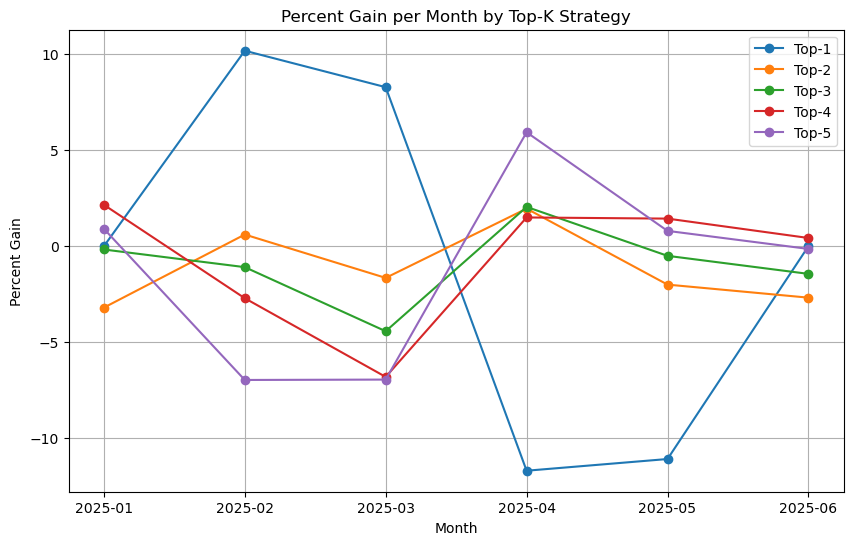

In [15]:
import os
import pandas as pd
import calendar
import matplotlib.pyplot as plt

# Folder containing the weights
portfolios_folder = "portfolio_management/portfolios"

# Find all relevant CSVs
all_files = [f for f in os.listdir(portfolios_folder) if f.startswith("top_") and f.endswith(".csv")]

# Organize by strategy and month
from collections import defaultdict
strategy_month_files = defaultdict(dict)
for f in all_files:
    # Example: top_1_weights_2025-01.csv
    parts = f.split("_")
    strategy = parts[1]  # '1', '2', etc.
    month_str = f.split("_")[-1].replace(".csv", "")  # '2025-01'
    strategy_month_files[strategy][month_str] = f
    print(f"Strategy: {strategy}, Month: {month_str}, File: {f}")
# Prepare to collect results
results = defaultdict(list)
months_sorted = sorted({m for d in strategy_month_files.values() for m in d})

for strategy in sorted(strategy_month_files.keys(), key=int):
    for month in months_sorted:
        if month not in strategy_month_files[strategy]:
            results[strategy].append(None)
            continue
        csv_path = os.path.join(portfolios_folder, strategy_month_files[strategy][month])
        weights_df = pd.read_csv(csv_path)
        allocations_dict = dict(zip(weights_df["Ticker"], weights_df["Weight"] * 100000))  # budget = 100000

        # Parse start and end date
        year, mon = map(int, month.split("-"))
        start_date = f"{year}-{mon:02d}-01"
        last_day = calendar.monthrange(year, mon)[1]
        end_date = f"{year}-{mon:02d}-{last_day}"

        # Run backtest
        result = run_custom_backtest(
            dataframes_dict=stock_data_dict,
            allocations_dict=allocations_dict,
            start_date=start_date,
            end_date=end_date,
            budget=100000
        )
        results[strategy].append(result['percent_gain'])

# Plot
plt.figure(figsize=(10, 6))
for strategy in sorted(results.keys(), key=int):
    plt.plot(months_sorted, results[strategy], marker='o', label=f"Top-{strategy}")
plt.title("Percent Gain per Month by Top-K Strategy")
plt.xlabel("Month")
plt.ylabel("Percent Gain")
plt.legend()
plt.grid(True)
plt.show()